# Unified Spectral Dynamics Comparison (v2)

Compares three methods for estimating trial-specific spectral dynamics:
1. **Raw Multitaper** (derotated to baseband)
2. **CT-SSMT (LFP-only)**
3. **CT-SSMT (Joint LFP + Spikes)**

## Key Features
- **NEW: Option to use averaged vs final latent estimates**
- **NEW: Posterior variance bands for joint method**
- Proper trial-averaged vs trial-averaged comparison
- Proper trial-specific vs trial-specific comparison
- Amplitude scaling to correct for absolute amplitude mismatches
- Publication-ready figure styling

## Data Format Notes
- **Ground truth Z_lat**: Baseband (unrotated) complex envelope
- **Raw Multitaper (MNE)**: Rotated → we derotate to baseband
- **Joint trace['latent']**: Rotated → we derotate to baseband

In [1]:
import sys, os, pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy.interpolate import interp1d
from scipy.stats import pearsonr
from simulate_trial_data import TrialSimConfig
WORKSPACE_PATH = "/orcd/data/ekmiller/001/bowen/spike-field-joint-inference"
if WORKSPACE_PATH not in sys.path:
    sys.path.append(WORKSPACE_PATH)

In [2]:
# Figure Styling
def figure_style(font_size=7):
    """Set publication-quality figure style"""
    sns.set(style="ticks", context="paper",
            font="sans-serif",
            rc={"font.size": font_size,
                "figure.titlesize": font_size,
                "axes.titlesize": font_size,
                "axes.labelsize": font_size,
                "axes.linewidth": 0.5,
                "lines.linewidth": 1,
                "lines.markersize": 3,
                "xtick.labelsize": font_size,
                "ytick.labelsize": font_size,
                "savefig.transparent": True,
                "xtick.major.size": 2.5,
                "ytick.major.size": 2.5,
                "xtick.major.width": 0.5,
                "ytick.major.width": 0.5,
                'legend.fontsize': font_size,
                'legend.title_fontsize': font_size,
                'legend.frameon': False,
            })
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    return None

METHOD_CONFIG = {
    "mt": {"label": "Multi-taper", "color": "#2E86AB", "linestyle": "-", "linewidth": 1.5},
    "lfp": {"label": "CT-SSMT (LFP-only)", "color": "#A23B72", "linestyle": "-", "linewidth": 1.5},
    "spk": {"label": "CT-SSMT (Joint)", "color": "#F18F01", "linestyle": "-", "linewidth": 1.5},
    "gt": {"label": "Ground Truth", "color": "#333333", "linestyle": "-", "linewidth": 1.0},
}

figure_style(font_size=8)

In [3]:
# ============================================================
# CONFIGURATION
# ============================================================

DATA_PATH = "./data/sim_with_trials.pkl"
JOINT_RESULTS_PATH = "./results/joint_inference.pkl"
CTSSMT_RESULTS_PATH = "./results/ctssmt_lfp_only.pkl"
OUTPUT_DIR = "./figures/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Spectral parameters
FS = 1000.0
WINDOW_SEC = 0.4
NW_PRODUCT = 1
FREQS_DENSE = np.arange(1, 61, 2, dtype=float)

# Visualization parameters
EXAMPLE_TRIALS = [0, 1, 57]
TIME_RANGE = (1.0, 8.0)

# ============================================================
# NEW: CHOOSE BETWEEN AVERAGED OR FINAL LATENT
# ============================================================
# Set to True to use averaged latent across refreshes
# Set to False to use final latent from last refresh
USE_AVERAGED_LATENT = True

print(f"USE_AVERAGED_LATENT = {USE_AVERAGED_LATENT}")

USE_AVERAGED_LATENT = True


## Helper Functions

In [4]:
def compute_optimal_scale(estimate, target):
    """Compute optimal scaling factor to match estimate to target."""
    est_flat = estimate.flatten()
    tgt_flat = target.flatten()
    if np.sum(est_flat**2) < 1e-10:
        return 1.0
    return np.dot(tgt_flat, est_flat) / np.dot(est_flat, est_flat)


def compute_metrics(estimate, target, scale=True):
    """Compute MSE and correlation between estimate and target."""
    est_flat = estimate.flatten()
    tgt_flat = target.flatten()
    if scale:
        scale_factor = compute_optimal_scale(estimate, target)
        est_scaled = est_flat * scale_factor
    else:
        scale_factor = 1.0
        est_scaled = est_flat
    mse = np.mean((est_scaled - tgt_flat)**2)
    corr = np.corrcoef(est_flat, tgt_flat)[0, 1]
    return mse, corr, scale_factor


def extract_complex_from_separated(lat_reim, J):
    """Convert SEPARATED format [Re_0..Re_{J-1}, Im_0..Im_{J-1}] to complex."""
    Z_re = lat_reim[:, :, :J]
    Z_im = lat_reim[:, :, J:]
    Z_complex = Z_re + 1j * Z_im
    return np.transpose(Z_complex, (0, 2, 1))


def extract_complex_from_interleaved(fine_state, J, M=1):
    """Convert INTERLEAVED format [Re_0, Im_0, Re_1, Im_1, ...] to complex."""
    fine_state = np.asarray(fine_state)
    if fine_state.ndim == 2:
        T_fine, D = fine_state.shape
        Z = np.zeros((J, T_fine), dtype=complex)
        for j in range(J):
            for m in range(M):
                base = (j * M + m) * 2
                Z[j, :] += fine_state[:, base] + 1j * fine_state[:, base + 1]
        return Z / M
    elif fine_state.ndim == 3:
        R_dim, T_fine, D = fine_state.shape
        Z = np.zeros((R_dim, J, T_fine), dtype=complex)
        for j in range(J):
            for m in range(M):
                base = (j * M + m) * 2
                Z[:, j, :] += fine_state[:, :, base] + 1j * fine_state[:, :, base + 1]
        return Z / M
    else:
        raise ValueError(f"Unexpected shape: {fine_state.shape}")


def extract_variance_from_interleaved(var_state, J, M=1):
    """Extract variance for each frequency from INTERLEAVED format."""
    var_state = np.asarray(var_state)
    if var_state.ndim == 2:
        T_fine, D = var_state.shape
        V = np.zeros((J, T_fine), dtype=float)
        for j in range(J):
            for m in range(M):
                base = (j * M + m) * 2
                V[j, :] += var_state[:, base] + var_state[:, base + 1]
        return V / (M * M)
    elif var_state.ndim == 3:
        R_dim, T_fine, D = var_state.shape
        V = np.zeros((R_dim, J, T_fine), dtype=float)
        for j in range(J):
            for m in range(M):
                base = (j * M + m) * 2
                V[:, j, :] += var_state[:, :, base] + var_state[:, :, base + 1]
        return V / (M * M)
    else:
        raise ValueError(f"Unexpected shape: {var_state.shape}")


def resample_to_target(Z_source, T_target, axis=-1):
    """Resample complex array along time axis to target length."""
    T_source = Z_source.shape[axis]
    if T_source == T_target:
        return Z_source
    t_source = np.linspace(0, 1, T_source)
    t_target = np.linspace(0, 1, T_target)
    if Z_source.ndim == 2:
        J = Z_source.shape[0]
        Z_resampled = np.zeros((J, T_target), dtype=Z_source.dtype)
        for j in range(J):
            if np.iscomplexobj(Z_source):
                f_re = interp1d(t_source, Z_source[j, :].real, kind='linear', fill_value='extrapolate')
                f_im = interp1d(t_source, Z_source[j, :].imag, kind='linear', fill_value='extrapolate')
                Z_resampled[j, :] = f_re(t_target) + 1j * f_im(t_target)
            else:
                f = interp1d(t_source, Z_source[j, :], kind='linear', fill_value='extrapolate')
                Z_resampled[j, :] = f(t_target)
        return Z_resampled
    elif Z_source.ndim == 3:
        R, J = Z_source.shape[:2]
        Z_resampled = np.zeros((R, J, T_target), dtype=Z_source.dtype)
        for r in range(R):
            for j in range(J):
                if np.iscomplexobj(Z_source):
                    f_re = interp1d(t_source, Z_source[r, j, :].real, kind='linear', fill_value='extrapolate')
                    f_im = interp1d(t_source, Z_source[r, j, :].imag, kind='linear', fill_value='extrapolate')
                    Z_resampled[r, j, :] = f_re(t_target) + 1j * f_im(t_target)
                else:
                    f = interp1d(t_source, Z_source[r, j, :], kind='linear', fill_value='extrapolate')
                    Z_resampled[r, j, :] = f(t_target)
        return Z_resampled
    else:
        raise ValueError(f"Unexpected shape: {Z_source.shape}")

## 1. Load Simulation Data

In [5]:
from simulate_trial_data import TrialSimConfig
print("="*70)
print("LOADING DATA")
print("="*70)

with open(DATA_PATH, "rb") as f:
    data = pickle.load(f)

LFP = data["LFP"]
spikes = data["spikes"]
Z_lat = data["Z_lat"]
freqs_true = np.asarray(data["freqs_hz"], float)
freqs_coupled = np.asarray(data.get("freqs_hz_coupled", freqs_true), float)
freqs_extra = np.asarray(data.get("freqs_hz_extra", []), float)
freqs_true_int = freqs_true.astype(int)
freqs_coupled_int = freqs_coupled.astype(int)
freqs_extra_int = freqs_extra.astype(int)
freqs_extra_set = set(freqs_extra_int.tolist())
masks = data["masks"]
time = data["time"]
delta_spk = data.get("delta_spk", 0.001)

R, T = LFP.shape
_, S, T_fine = spikes.shape
J_true = len(freqs_true)
B = len(FREQS_DENSE)

print(f"LFP: {LFP.shape}")
print(f"Ground truth Z_lat: {Z_lat.shape} (BASEBAND)")
print(f"True frequencies: {freqs_true} Hz")

idx_true_to_dense = np.array([np.argmin(np.abs(FREQS_DENSE - f)) for f in freqs_true])
print(f"True freq -> dense idx: {dict(zip(freqs_true, idx_true_to_dense))}")

Z_gt = np.zeros((R, B, T), dtype=complex)
for j_true, j_dense in enumerate(idx_true_to_dense):
    Z_gt[:, j_dense, :] = Z_lat[:, j_true, :]

print(f"Ground truth expanded: {Z_gt.shape}")

LOADING DATA
LFP: (100, 10000)
Ground truth Z_lat: (100, 6, 10000) (BASEBAND)
True frequencies: [11. 19. 27. 43.  7. 35.] Hz
True freq -> dense idx: {np.float64(11.0): np.int64(5), np.float64(19.0): np.int64(9), np.float64(27.0): np.int64(13), np.float64(43.0): np.int64(21), np.float64(7.0): np.int64(3), np.float64(35.0): np.int64(17)}
Ground truth expanded: (100, 30, 10000)


## 2. Compute Raw Multitaper (DEROTATED)

In [6]:
import mne
from src.utils_multitaper import derotate_tfr_align_start

def compute_multitaper_derotated(lfp, fs, freqs, window_sec, NW_product):
    R, T = lfp.shape
    tfr_raw = mne.time_frequency.tfr_array_multitaper(
        lfp[:, None, :], sfreq=fs, freqs=freqs, n_cycles=freqs * window_sec,
        time_bandwidth=2 * NW_product, output="complex", zero_mean=False,
    ).squeeze()
    tfr_raw_mt = tfr_raw[:, :, None, :]
    M = int(round(window_sec * fs))
    tfr_derotated = derotate_tfr_align_start(tfr_raw_mt, freqs, fs, 1, M)
    tapers, _ = mne.time_frequency.multitaper.dpss_windows(M, NW_product, Kmax=1)
    tfr_derotated = tfr_derotated * (2.0 / tapers.sum(axis=1))
    return tfr_derotated.squeeze(axis=2), tfr_raw

print("Recomputing multitaper with derotation...")
Z_mt, tfr_raw_rotated = compute_multitaper_derotated(LFP, FS, FREQS_DENSE, WINDOW_SEC, NW_PRODUCT)
print(f"Z_mt (derotated): {Z_mt.shape}")

Recomputing multitaper with derotation...
Z_mt (derotated): (100, 30, 10000)


## 3. Load CT-SSMT (LFP-only) Results

In [7]:
Z_lfp = None
HAS_LFP = False

if os.path.exists(CTSSMT_RESULTS_PATH):
    with open(CTSSMT_RESULTS_PATH, 'rb') as f:
        ctssmt_results = pickle.load(f)
    print(f"Keys: {list(ctssmt_results.keys())}")
    if 'Z_smooth_full' in ctssmt_results:
        Z_lfp = ctssmt_results['Z_smooth_full']
    elif 'Z_smooth' in ctssmt_results:
        Z_lfp = ctssmt_results['Z_smooth']
    if Z_lfp is not None:
        Z_lfp = resample_to_target(Z_lfp, T)
        print(f"CT-SSMT (LFP-only): {Z_lfp.shape}")
        HAS_LFP = True
else:
    print(f"CT-SSMT results not found at {CTSSMT_RESULTS_PATH}")

Keys: ['Z_smooth_full', 'Z_mean_fine', 'Z_var_fine', 'X_mean_fine', 'tfr', 'Y_trials', 'params', 'freqs', 'config', 'block_size', 'ground_truth']
CT-SSMT (LFP-only): (100, 30, 10000)


## 4. Load Joint Inference Results

In [8]:
Z_spk = None
X_shared = None
D_deviation = None
Z_spk_var = None
HAS_SPK = False

def derotate_tfr(tfr_rotated, freqs, time):
    R, J, T_dim = tfr_rotated.shape
    tfr_baseband = np.zeros_like(tfr_rotated)
    for j, f in enumerate(freqs):
        phase = 2.0 * np.pi * f * time
        tfr_baseband[:, j, :] = tfr_rotated[:, j, :] * np.exp(-1j * phase)[None, :]
    return tfr_baseband

if os.path.exists(JOINT_RESULTS_PATH):
    with open(JOINT_RESULTS_PATH, "rb") as f:
        joint_results = pickle.load(f)
    trace = joint_results['trace']
    freqs_joint = joint_results['freqs_dense']
    J_joint = len(freqs_joint)
    print(f"Trace keys: {list(trace.keys())}")
    
    if 'latent' in trace and len(trace['latent']) > 0:
        lat_reim = np.asarray(trace['latent'][-1])
        print(f"  trace['latent'] shape: {lat_reim.shape}")
        R_lat, T_lat, twoJ = lat_reim.shape
        J_lat = twoJ // 2
        if 'latent_scale_factors' in trace:
            scale_factors = np.asarray(trace['latent_scale_factors'])
            print(f"  Rescaling by scale_factors")
            lat_reim = lat_reim * scale_factors[None, None, :]
        Z_joint_rotated = extract_complex_from_separated(lat_reim, J_lat)
        Z_joint_rotated = resample_to_target(Z_joint_rotated, T)
        Z_spk = derotate_tfr(Z_joint_rotated, freqs_joint, time)
        print(f"  Joint (derotated): {Z_spk.shape}")
        HAS_SPK = True
    
    # Load X_fine and D_fine (averaged or final)
    if USE_AVERAGED_LATENT:
        X_key = 'X_fine_avg' if 'X_fine_avg' in trace else 'X_fine'
        D_key = 'D_fine_avg' if 'D_fine_avg' in trace else 'D_fine'
        print(f"  Using AVERAGED latent: {X_key}, {D_key}")
    else:
        X_key = 'X_fine_final' if 'X_fine_final' in trace else 'X_fine'
        D_key = 'D_fine_final' if 'D_fine_final' in trace else 'D_fine'
        print(f"  Using FINAL latent: {X_key}, {D_key}")
    
    if X_key in trace:
        X_fine_raw = trace[X_key]
        X_fine = np.asarray(X_fine_raw[-1] if isinstance(X_fine_raw, list) else X_fine_raw)
        print(f"  {X_key} shape: {X_fine.shape}")
    else:
        X_fine = None
    
    if D_key in trace:
        D_fine_raw = trace[D_key]
        D_fine = np.asarray(D_fine_raw[-1] if isinstance(D_fine_raw, list) else D_fine_raw)
        print(f"  {D_key} shape: {D_fine.shape}")
    else:
        D_fine = None
    
    if X_fine is not None and D_fine is not None:
        X_shared = extract_complex_from_interleaved(X_fine, J_joint)
        D_deviation = extract_complex_from_interleaved(D_fine, J_joint)
        X_shared = resample_to_target(X_shared, T)
        D_deviation = resample_to_target(D_deviation, T)
        print(f"  X_shared: {X_shared.shape}")
        print(f"  D_deviation: {D_deviation.shape}")
    
    # Load posterior variance
    X_var_key = 'X_var_fine_final' if 'X_var_fine_final' in trace else 'X_var_fine'
    D_var_key = 'D_var_fine_final' if 'D_var_fine_final' in trace else 'D_var_fine'
    X_var_fine, D_var_fine = None, None
    
    if X_var_key in trace:
        X_var_raw = trace[X_var_key]
        X_var_fine = np.asarray(X_var_raw[-1] if isinstance(X_var_raw, list) else X_var_raw)
        print(f"  {X_var_key} shape: {X_var_fine.shape}")
    if D_var_key in trace:
        D_var_raw = trace[D_var_key]
        D_var_fine = np.asarray(D_var_raw[-1] if isinstance(D_var_raw, list) else D_var_raw)
        print(f"  {D_var_key} shape: {D_var_fine.shape}")
    
    if X_var_fine is not None and D_var_fine is not None:
        X_var_freq = extract_variance_from_interleaved(X_var_fine, J_joint)
        D_var_freq = extract_variance_from_interleaved(D_var_fine, J_joint)
        Z_spk_var = X_var_freq[None, :, :] + D_var_freq
        Z_spk_var = resample_to_target(Z_spk_var, T)
        print(f"  Z_spk_var (posterior variance): {Z_spk_var.shape}")
    else:
        print(f"  WARNING: Posterior variance not available")
else:
    print(f"Joint results not found at {JOINT_RESULTS_PATH}")

Trace keys: ['beta', 'gamma', 'X_fine_final', 'D_fine_final', 'X_var_fine_final', 'D_var_fine_final', 'X_fine_avg', 'D_fine_avg', 'latent', 'latent_scale_factors', 'shrinkage_factors', 'wald_significant_mask', 'wald_W_stats', 'wald_p_values']
  trace['latent'] shape: (100, 9800, 60)
  Rescaling by scale_factors
  Joint (derotated): (100, 30, 10000)
  Using AVERAGED latent: X_fine_avg, D_fine_avg
  X_fine_avg shape: (9800, 60)
  D_fine_avg shape: (100, 9800, 60)
  X_shared: (30, 10000)
  D_deviation: (100, 30, 10000)
  X_var_fine_final shape: (9800, 60)
  D_var_fine_final shape: (100, 9800, 60)
  Z_spk_var (posterior variance): (100, 30, 10000)


In [9]:
# Summary
print("="*70)
print("DATA SUMMARY")
print("="*70)
print(f"Ground truth: {Z_gt.shape}")
print(f"Multitaper:   {Z_mt.shape}")
print(f"LFP-only:     {Z_lfp.shape if HAS_LFP else 'N/A'}")
print(f"Joint:        {Z_spk.shape if HAS_SPK else 'N/A'}")
print(f"X_shared:     {X_shared.shape if X_shared is not None else 'N/A'}")
print(f"D_deviation:  {D_deviation.shape if D_deviation is not None else 'N/A'}")
print(f"Z_spk_var:    {Z_spk_var.shape if Z_spk_var is not None else 'N/A'}")

DATA SUMMARY
Ground truth: (100, 30, 10000)
Multitaper:   (100, 30, 10000)
LFP-only:     (100, 30, 10000)
Joint:        (100, 30, 10000)
X_shared:     (30, 10000)
D_deviation:  (100, 30, 10000)
Z_spk_var:    (100, 30, 10000)


## Figure 1: Trial-Specific Comparison with Posterior Variance

Global scale factors: MT=0.2401, LFP=0.7330, Joint=0.5210


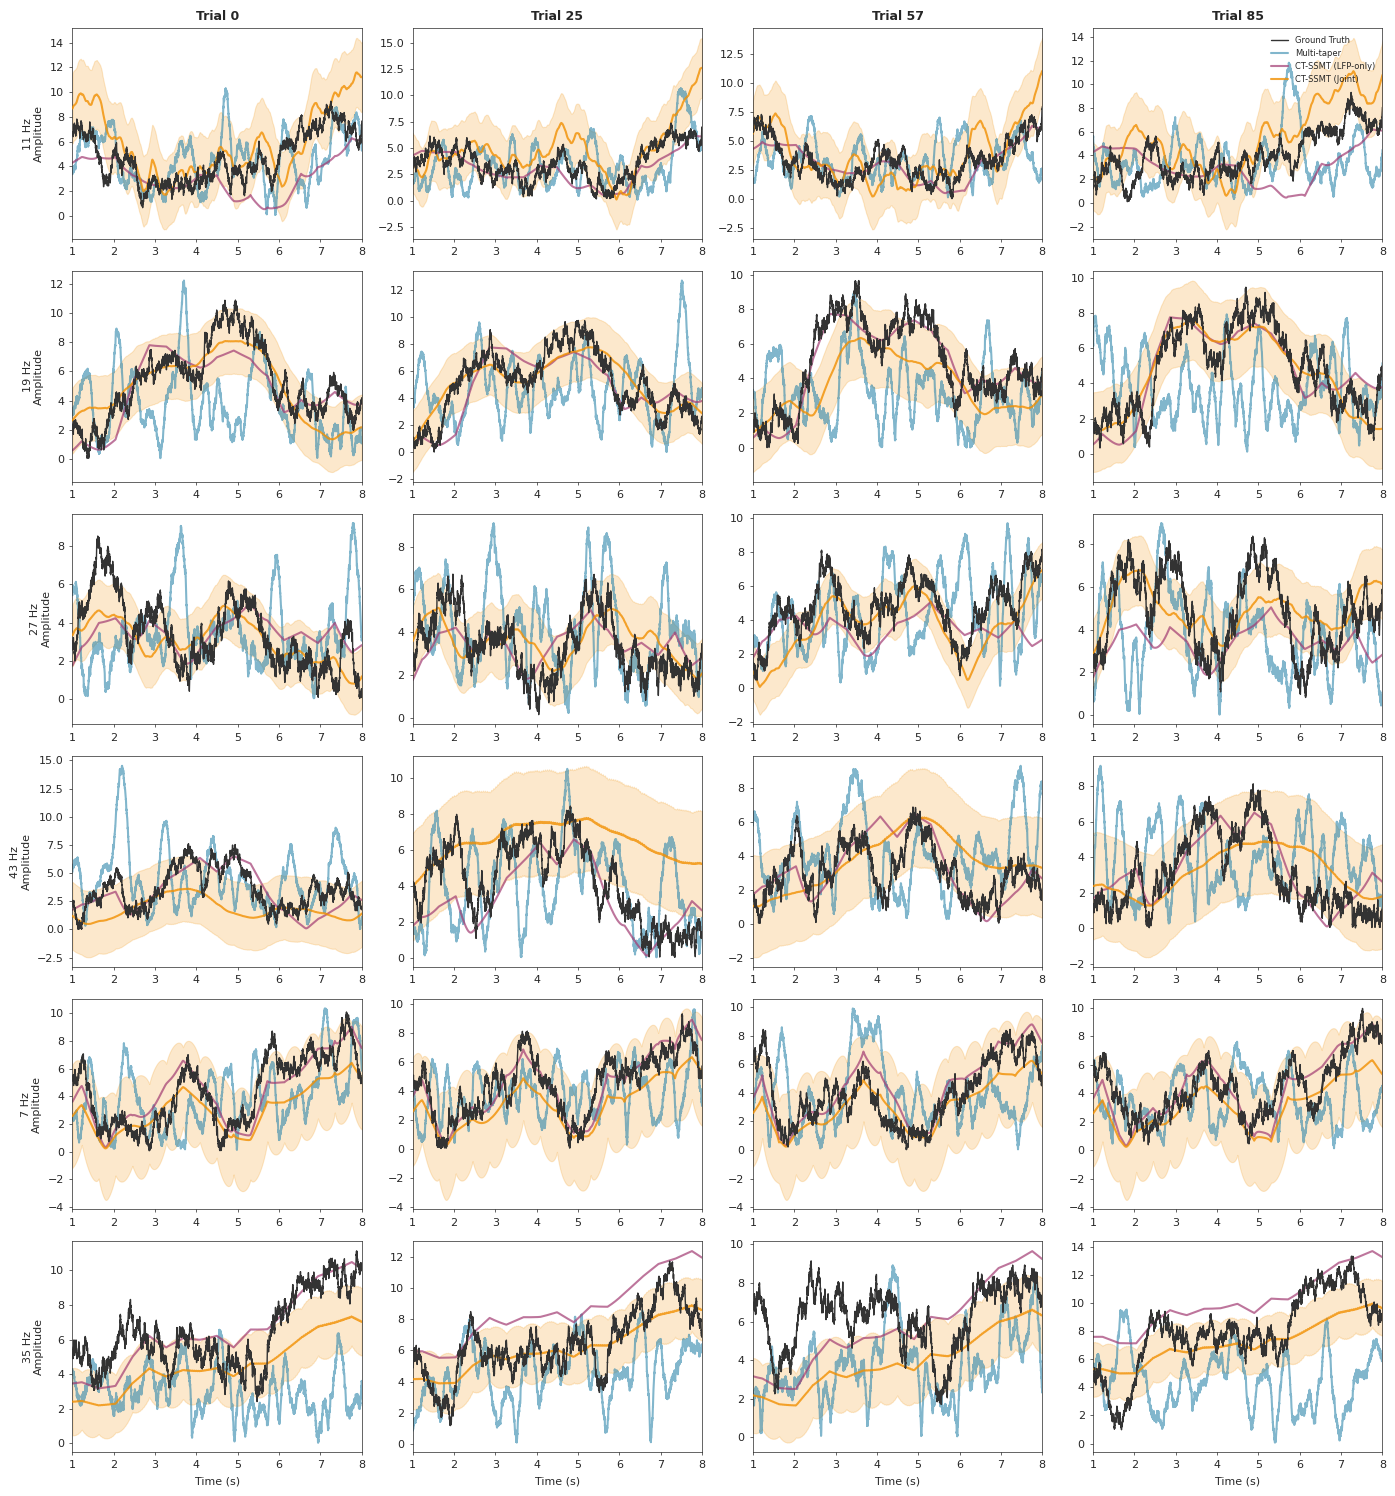


Trial-specific correlations with ground truth:
Trial    Freq             MT        LFP      Joint
--------------------------------------------------
0        11 Hz         0.195      0.786      0.865
0        19 Hz         0.164      0.846      0.848
0        27 Hz        -0.148      0.699      0.822
0        43 Hz        -0.060      0.823      0.682
0        7 Hz (signal-only)         0.275      0.853      0.853
0        35 Hz (signal-only)         0.450      0.912      0.910
25       11 Hz         0.102      0.911      0.909
25       19 Hz         0.224      0.831      0.884
25       27 Hz         0.260      0.895      0.884
25       43 Hz         0.422      0.816      0.620
25       7 Hz (signal-only)         0.163      0.869      0.869
25       35 Hz (signal-only)         0.401      0.923      0.922
57       11 Hz         0.359      0.939      0.933
57       19 Hz        -0.016      0.897      0.762
57       27 Hz         0.284      0.722      0.897
57       43 Hz         0.002   

In [10]:
# ============================================================
# PLOT 1: Trial-Specific Comparison (4 sample trials)
# ============================================================

figure_style(font_size=8)
SAMPLE_TRIALS = [0, 25, 57, 85]

def compute_global_scale(estimate, target, freq_indices):
    est_flat = np.abs(estimate[:, freq_indices, :]).flatten()
    tgt_flat = np.abs(target[:, freq_indices, :]).flatten()
    if np.sum(est_flat**2) < 1e-10:
        return 1.0
    return np.dot(tgt_flat, est_flat) / np.dot(est_flat, est_flat)

scale_mt_global = compute_global_scale(Z_mt, Z_gt, idx_true_to_dense)
scale_lfp_global = compute_global_scale(Z_lfp, Z_gt, idx_true_to_dense) if HAS_LFP else 1.0
scale_spk_global = compute_global_scale(Z_spk, Z_gt, idx_true_to_dense) if HAS_SPK else 1.0

print(f"Global scale factors: MT={scale_mt_global:.4f}, LFP={scale_lfp_global:.4f}, Joint={scale_spk_global:.4f}")

n_freqs = len(freqs_true)
n_trials = len(SAMPLE_TRIALS)
fig, axes = plt.subplots(n_freqs, n_trials, figsize=(3.5*n_trials, 2.5*n_freqs), squeeze=False)

t_mask = (time >= TIME_RANGE[0]) & (time <= TIME_RANGE[1])
t_plot = time[t_mask]

for i, (j_true, freq_hz) in enumerate(zip(range(J_true), freqs_true)):
    j_dense = idx_true_to_dense[j_true]
    for j, trial_idx in enumerate(SAMPLE_TRIALS):
        ax = axes[i, j]
        amp_gt_trial = np.abs(Z_gt[trial_idx, j_dense, t_mask])
        ax.plot(t_plot, amp_gt_trial, color=METHOD_CONFIG['gt']['color'], 
                lw=METHOD_CONFIG['gt']['linewidth'], label='Ground Truth', zorder=5)
        
        amp_mt_trial = np.abs(Z_mt[trial_idx, j_dense, t_mask]) * scale_mt_global
        ax.plot(t_plot, amp_mt_trial, color=METHOD_CONFIG['mt']['color'], 
                lw=METHOD_CONFIG['mt']['linewidth'], label=METHOD_CONFIG['mt']['label'], alpha=0.6, zorder=1)
        
        if HAS_LFP:
            amp_lfp_trial = np.abs(Z_lfp[trial_idx, j_dense, t_mask]) * scale_lfp_global
            ax.plot(t_plot, amp_lfp_trial, color=METHOD_CONFIG['lfp']['color'], 
                    lw=METHOD_CONFIG['lfp']['linewidth'], label=METHOD_CONFIG['lfp']['label'], alpha=0.7, zorder=2)
        
        if HAS_SPK:
            amp_spk_trial = np.abs(Z_spk[trial_idx, j_dense, t_mask]) * scale_spk_global
            ax.plot(t_plot, amp_spk_trial, color=METHOD_CONFIG['spk']['color'], 
                    lw=METHOD_CONFIG['spk']['linewidth'], label=METHOD_CONFIG['spk']['label'], alpha=0.8, zorder=3)
            if Z_spk_var is not None:
                std_spk_trial = np.sqrt(Z_spk_var[trial_idx, j_dense, t_mask]) * scale_spk_global
                ax.fill_between(t_plot, amp_spk_trial - std_spk_trial, amp_spk_trial + std_spk_trial,
                                color=METHOD_CONFIG['spk']['color'], alpha=0.2, zorder=0)
        
        ax.set_xlim(TIME_RANGE)
        if i == 0: ax.set_title(f'Trial {trial_idx}', fontsize=9, fontweight='bold')
        if j == 0: ax.set_ylabel(f'{freq_hz:.0f} Hz\nAmplitude', fontsize=8)
        if i == 0 and j == n_trials - 1: ax.legend(loc='upper right', fontsize=6)
        if i == n_freqs - 1: ax.set_xlabel('Time (s)', fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'trial_specific_4trials.pdf'), dpi=150, bbox_inches='tight')
plt.savefig(os.path.join(OUTPUT_DIR, 'trial_specific_4trials.png'), dpi=150, bbox_inches='tight')
plt.show()

print("\nTrial-specific correlations with ground truth:")
print(f"{'Trial':<8} {'Freq':<8} {'MT':>10} {'LFP':>10} {'Joint':>10}")
print("-"*50)
for trial_idx in SAMPLE_TRIALS:
    for j_true, freq_hz in enumerate(freqs_true):
        j_dense = idx_true_to_dense[j_true]
        gt = np.abs(Z_gt[trial_idx, j_dense, :])
        r_mt = np.corrcoef(gt, np.abs(Z_mt[trial_idx, j_dense, :]))[0, 1]
        r_lfp = np.corrcoef(gt, np.abs(Z_lfp[trial_idx, j_dense, :]))[0, 1] if HAS_LFP else np.nan
        r_spk = np.corrcoef(gt, np.abs(Z_spk[trial_idx, j_dense, :]))[0, 1] if HAS_SPK else np.nan
        tag = ' (signal-only)' if int(freq_hz) in freqs_extra_set else ''
        print(f"{trial_idx:<8} {freq_hz:.0f} Hz{tag}{'':<3} {r_mt:>10.3f} {r_lfp:>10.3f} {r_spk:>10.3f}")

## Figure 2: Deviation Term Comparison

Deviation scale factors: MT=0.0845, LFP=0.3923, Joint=0.2877


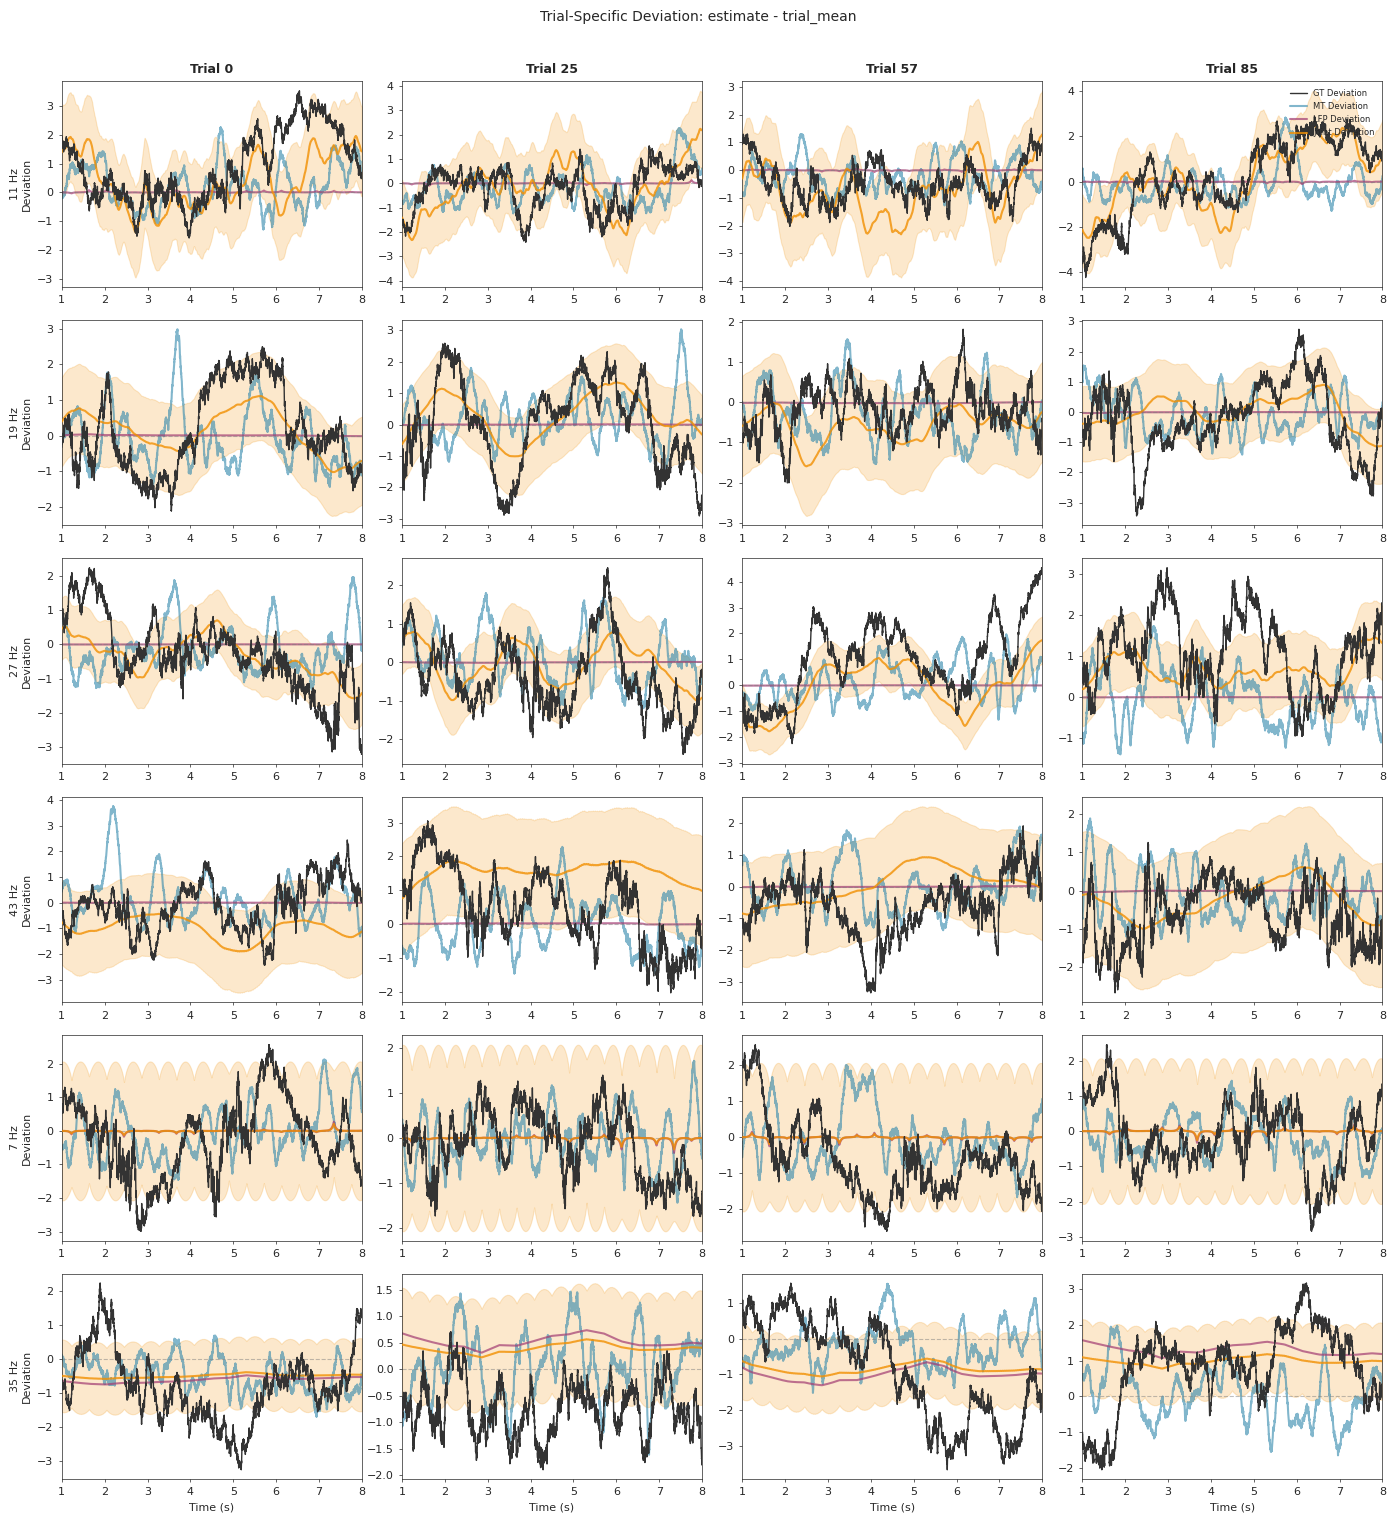


Deviation correlations with ground truth deviation:
Trial    Freq             MT        LFP      Joint
--------------------------------------------------
0        11 Hz         0.153      0.079      0.534
0        19 Hz         0.099      0.049      0.549
0        27 Hz        -0.117     -0.030      0.705
0        43 Hz         0.027     -0.311      0.264
0        7 Hz         0.019      0.010      0.010
0        35 Hz         0.322     -0.101     -0.299
25       11 Hz         0.075      0.042      0.495
25       19 Hz         0.007      0.424      0.626
25       27 Hz         0.163      0.106      0.533
25       43 Hz         0.152      0.476      0.185
25       7 Hz         0.248      0.176      0.176
25       35 Hz         0.239      0.116      0.085
57       11 Hz         0.062     -0.003      0.536
57       19 Hz        -0.040     -0.160     -0.156
57       27 Hz         0.009      0.460      0.833
57       43 Hz         0.080      0.452     -0.206
57       7 Hz        -0.164    

In [11]:
# ============================================================
# PLOT 2: Deviation Term Comparison
# ============================================================

figure_style(font_size=8)

Z_gt_mean = np.abs(Z_gt).mean(axis=0)
Z_mt_mean = np.abs(Z_mt).mean(axis=0)
Z_lfp_mean = np.abs(Z_lfp).mean(axis=0) if HAS_LFP else None
Z_spk_mean = np.abs(Z_spk).mean(axis=0) if HAS_SPK else None

Z_gt_dev = np.abs(Z_gt) - Z_gt_mean[None, :, :]
Z_mt_dev = np.abs(Z_mt) - Z_mt_mean[None, :, :]
Z_lfp_dev = np.abs(Z_lfp) - Z_lfp_mean[None, :, :] if HAS_LFP else None
Z_spk_dev = np.abs(Z_spk) - Z_spk_mean[None, :, :] if HAS_SPK else None

D_amplitude = np.abs(D_deviation) if D_deviation is not None else None

def compute_dev_scale(dev_est, dev_gt, freq_indices):
    est = dev_est[:, freq_indices, :].flatten()
    gt = dev_gt[:, freq_indices, :].flatten()
    if np.sum(np.abs(est)**2) < 1e-10:
        return 1.0
    return np.dot(np.abs(gt), np.abs(est)) / np.dot(np.abs(est), np.abs(est))

scale_mt_dev = compute_dev_scale(Z_mt_dev, Z_gt_dev, idx_true_to_dense)
scale_lfp_dev = compute_dev_scale(Z_lfp_dev, Z_gt_dev, idx_true_to_dense) if HAS_LFP else 1.0
scale_spk_dev = compute_dev_scale(Z_spk_dev, Z_gt_dev, idx_true_to_dense) if HAS_SPK else 1.0

print(f"Deviation scale factors: MT={scale_mt_dev:.4f}, LFP={scale_lfp_dev:.4f}, Joint={scale_spk_dev:.4f}")

fig, axes = plt.subplots(n_freqs, n_trials, figsize=(3.5*n_trials, 2.5*n_freqs), squeeze=False)

for i, (j_true, freq_hz) in enumerate(zip(range(J_true), freqs_true)):
    j_dense = idx_true_to_dense[j_true]
    for j, trial_idx in enumerate(SAMPLE_TRIALS):
        ax = axes[i, j]
        dev_gt_trial = Z_gt_dev[trial_idx, j_dense, t_mask]
        ax.plot(t_plot, dev_gt_trial, color=METHOD_CONFIG['gt']['color'], 
                lw=METHOD_CONFIG['gt']['linewidth'], label='GT Deviation', zorder=5)
        
        dev_mt_trial = Z_mt_dev[trial_idx, j_dense, t_mask] * scale_mt_dev
        ax.plot(t_plot, dev_mt_trial, color=METHOD_CONFIG['mt']['color'], 
                lw=METHOD_CONFIG['mt']['linewidth'], label='MT Deviation', alpha=0.6, zorder=1)
        
        if HAS_LFP and Z_lfp_dev is not None:
            dev_lfp_trial = Z_lfp_dev[trial_idx, j_dense, t_mask] * scale_lfp_dev
            ax.plot(t_plot, dev_lfp_trial, color=METHOD_CONFIG['lfp']['color'], 
                    lw=METHOD_CONFIG['lfp']['linewidth'], label='LFP Deviation', alpha=0.7, zorder=2)
        
        if HAS_SPK and Z_spk_dev is not None:
            dev_spk_trial = Z_spk_dev[trial_idx, j_dense, t_mask] * scale_spk_dev
            ax.plot(t_plot, dev_spk_trial, color=METHOD_CONFIG['spk']['color'], 
                    lw=METHOD_CONFIG['spk']['linewidth'], label='Joint Deviation', alpha=0.8, zorder=3)
            if Z_spk_var is not None:
                std_spk_trial = np.sqrt(Z_spk_var[trial_idx, j_dense, t_mask]) * scale_spk_dev
                ax.fill_between(t_plot, dev_spk_trial - std_spk_trial, dev_spk_trial + std_spk_trial,
                                color=METHOD_CONFIG['spk']['color'], alpha=0.2, zorder=0)
        
        ax.axhline(0, color='gray', linestyle='--', lw=0.8, alpha=0.5)
        ax.set_xlim(TIME_RANGE)
        if i == 0: ax.set_title(f'Trial {trial_idx}', fontsize=9, fontweight='bold')
        if j == 0: ax.set_ylabel(f'{freq_hz:.0f} Hz\nDeviation', fontsize=8)
        if i == 0 and j == n_trials - 1: ax.legend(loc='upper right', fontsize=6)
        if i == n_freqs - 1: ax.set_xlabel('Time (s)', fontsize=8)

plt.suptitle('Trial-Specific Deviation: estimate - trial_mean', fontsize=10, y=1.01)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'deviation_comparison_4trials.pdf'), dpi=150, bbox_inches='tight')
plt.savefig(os.path.join(OUTPUT_DIR, 'deviation_comparison_4trials.png'), dpi=150, bbox_inches='tight')
plt.show()

print("\nDeviation correlations with ground truth deviation:")
print(f"{'Trial':<8} {'Freq':<8} {'MT':>10} {'LFP':>10} {'Joint':>10}")
print("-"*50)
for trial_idx in SAMPLE_TRIALS:
    for j_true, freq_hz in enumerate(freqs_true):
        j_dense = idx_true_to_dense[j_true]
        gt_dev = Z_gt_dev[trial_idx, j_dense, :]
        r_mt = np.corrcoef(gt_dev, Z_mt_dev[trial_idx, j_dense, :])[0, 1]
        r_lfp = np.corrcoef(gt_dev, Z_lfp_dev[trial_idx, j_dense, :])[0, 1] if HAS_LFP else np.nan
        r_spk = np.corrcoef(gt_dev, Z_spk_dev[trial_idx, j_dense, :])[0, 1] if HAS_SPK else np.nan
        print(f"{trial_idx:<8} {freq_hz:.0f} Hz{'':<3} {r_mt:>10.3f} {r_lfp:>10.3f} {r_spk:>10.3f}")

print("\n" + "="*50)
print("AGGREGATE DEVIATION METRICS")
print("="*50)
dev_gt_all = Z_gt_dev[:, idx_true_to_dense, :].flatten()
dev_mt_all = Z_mt_dev[:, idx_true_to_dense, :].flatten()
print(f"Multi-taper deviation correlation:    r = {np.corrcoef(dev_gt_all, dev_mt_all)[0, 1]:.3f}")
if HAS_LFP:
    dev_lfp_all = Z_lfp_dev[:, idx_true_to_dense, :].flatten()
    print(f"CT-SSMT (LFP) deviation correlation:  r = {np.corrcoef(dev_gt_all, dev_lfp_all)[0, 1]:.3f}")
if HAS_SPK:
    dev_spk_all = Z_spk_dev[:, idx_true_to_dense, :].flatten()
    print(f"CT-SSMT (Joint) deviation correlation: r = {np.corrcoef(dev_gt_all, dev_spk_all)[0, 1]:.3f}")

## Figure 3: Trial-Averaged Comparison (Line Plots)

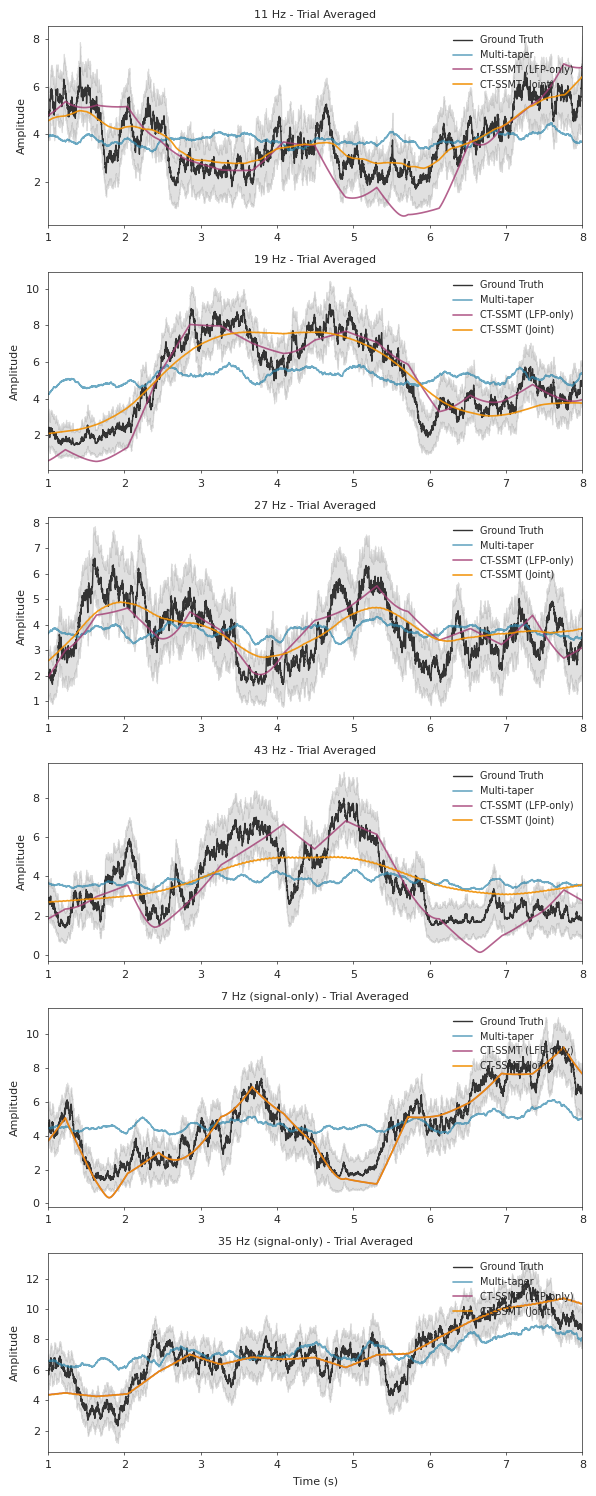

In [12]:
figure_style(font_size=8)
fig, axes = plt.subplots(len(freqs_true), 1, figsize=(6, 2.5*len(freqs_true)))
if len(freqs_true) == 1: axes = [axes]

for i, (j_true, freq_hz) in enumerate(zip(range(J_true), freqs_true)):
    j_dense = idx_true_to_dense[j_true]
    ax = axes[i]
    amp_gt = np.abs(Z_gt[:, j_dense, :])[:, t_mask]
    mean_gt = amp_gt.mean(axis=0)
    std_gt = amp_gt.std(axis=0)
    ax.plot(t_plot, mean_gt, color=METHOD_CONFIG['gt']['color'], lw=1.0, label='Ground Truth')
    ax.fill_between(t_plot, mean_gt - std_gt, mean_gt + std_gt, color=METHOD_CONFIG['gt']['color'], alpha=0.15)
    
    amp_mt = np.abs(Z_mt[:, j_dense, :])[:, t_mask]
    mean_mt = amp_mt.mean(axis=0)
    scale_mt = compute_optimal_scale(mean_mt, mean_gt)
    ax.plot(t_plot, mean_mt * scale_mt, color=METHOD_CONFIG['mt']['color'], lw=1.2,
            label=METHOD_CONFIG['mt']['label'], alpha=0.7)
    
    if HAS_LFP:
        amp_lfp = np.abs(Z_lfp[:, j_dense, :])[:, t_mask]
        mean_lfp = amp_lfp.mean(axis=0)
        scale_lfp = compute_optimal_scale(mean_lfp, mean_gt)
        ax.plot(t_plot, mean_lfp * scale_lfp, color=METHOD_CONFIG['lfp']['color'], lw=1.2,
                label=METHOD_CONFIG['lfp']['label'], alpha=0.8)
    
    if HAS_SPK:
        amp_spk = np.abs(Z_spk[:, j_dense, :])[:, t_mask]
        mean_spk = amp_spk.mean(axis=0)
        scale_spk = compute_optimal_scale(mean_spk, mean_gt)
        ax.plot(t_plot, mean_spk * scale_spk, color=METHOD_CONFIG['spk']['color'], lw=1.2,
                label=METHOD_CONFIG['spk']['label'], alpha=0.9)
    
    ax.set_ylabel('Amplitude')
    tag = ' (signal-only)' if int(freq_hz) in freqs_extra_set else ''
    ax.set_title(f'{freq_hz:.0f} Hz{tag} - Trial Averaged')
    ax.legend(loc='upper right', fontsize=7)
    ax.set_xlim(TIME_RANGE)

axes[-1].set_xlabel('Time (s)')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'trial_averaged_comparison.pdf'), dpi=150, bbox_inches='tight')
plt.savefig(os.path.join(OUTPUT_DIR, 'trial_averaged_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

## Summary Metrics

In [13]:
print("="*70)
print("AGGREGATE AMPLITUDE CORRELATIONS")
print("="*70)
for j_true, freq_hz in enumerate(freqs_true):
    j_dense = idx_true_to_dense[j_true]
    gt_flat = np.abs(Z_gt[:, j_dense, :]).flatten()
    r_mt = np.corrcoef(gt_flat, np.abs(Z_mt[:, j_dense, :]).flatten())[0, 1]
    r_lfp = np.corrcoef(gt_flat, np.abs(Z_lfp[:, j_dense, :]).flatten())[0, 1] if HAS_LFP else np.nan
    r_spk = np.corrcoef(gt_flat, np.abs(Z_spk[:, j_dense, :]).flatten())[0, 1] if HAS_SPK else np.nan
    print(f"{freq_hz:.0f} Hz: MT={r_mt:.3f}, LFP={r_lfp:.3f}, Joint={r_spk:.3f}")

gt_all = np.abs(Z_gt[:, idx_true_to_dense, :]).flatten()
mt_all = np.abs(Z_mt[:, idx_true_to_dense, :]).flatten()
r_mt_all = np.corrcoef(gt_all, mt_all)[0, 1]
r_lfp_all = np.corrcoef(gt_all, np.abs(Z_lfp[:, idx_true_to_dense, :]).flatten())[0, 1] if HAS_LFP else np.nan
r_spk_all = np.corrcoef(gt_all, np.abs(Z_spk[:, idx_true_to_dense, :]).flatten())[0, 1] if HAS_SPK else np.nan
print("-"*50)
print(f"OVERALL: MT={r_mt_all:.3f}, LFP={r_lfp_all:.3f}, Joint={r_spk_all:.3f}")

AGGREGATE AMPLITUDE CORRELATIONS
11 Hz: MT=0.173, LFP=0.857, Joint=0.876
19 Hz: MT=0.127, LFP=0.833, Joint=0.790
27 Hz: MT=0.130, LFP=0.818, Joint=0.841
43 Hz: MT=0.105, LFP=0.779, Joint=0.491
7 Hz: MT=0.135, LFP=0.841, Joint=0.841
35 Hz: MT=0.265, LFP=0.828, Joint=0.817
--------------------------------------------------
OVERALL: MT=0.189, LFP=0.862, Joint=0.739


## X/D Variance Decomposition

In [14]:
if X_shared is not None and D_deviation is not None:
    print("="*70)
    print("X/D VARIANCE DECOMPOSITION")
    print("="*70)
    print(f"{'Frequency':<12} {'X var %':<12} {'D var %':<12} {'r(X, GT)':<12} {'r(X+D, GT)':<12}")
    print("-"*70)
    for j_true, freq_hz in enumerate(freqs_true):
        j_dense = idx_true_to_dense[j_true]
        amp_gt = np.abs(Z_gt[:, j_dense, :]).flatten()
        amp_X = np.abs(np.broadcast_to(X_shared[j_dense:j_dense+1, :], (R, T))).flatten()
        Z_XD_here = X_shared[j_dense, :] + D_deviation[:, j_dense, :]
        amp_XD = np.abs(Z_XD_here).flatten()
        var_X = np.var(np.abs(X_shared[j_dense, :]))
        var_D = np.var(np.abs(D_deviation[:, j_dense, :]))
        total_var = var_X + var_D
        pct_X = 100 * var_X / total_var if total_var > 0 else 0
        pct_D = 100 * var_D / total_var if total_var > 0 else 0
        r_X = np.corrcoef(amp_gt, amp_X)[0, 1]
        r_XD = np.corrcoef(amp_gt, amp_XD)[0, 1]
        print(f"{freq_hz:.0f} Hz{'':<6} {pct_X:<12.1f} {pct_D:<12.1f} {r_X:<12.3f} {r_XD:<12.3f}")
    print("-"*70)
    amp_gt_all = np.abs(Z_gt[:, idx_true_to_dense, :]).flatten()
    amp_X_all = np.abs(np.broadcast_to(X_shared[idx_true_to_dense, :][None, :, :], (R, J_true, T))).flatten()
    Z_XD_all = X_shared[idx_true_to_dense, :] + D_deviation[:, idx_true_to_dense, :]
    amp_XD_all = np.abs(Z_XD_all).flatten()
    r_X_agg = np.corrcoef(amp_gt_all, amp_X_all)[0, 1]
    r_XD_agg = np.corrcoef(amp_gt_all, amp_XD_all)[0, 1]
    print(f"{'AGGREGATE':<12} {'-':<12} {'-':<12} {r_X_agg:<12.3f} {r_XD_agg:<12.3f}")
    if r_XD_agg > r_X_agg + 0.01:
        print("\n✓ D contributes meaningful trial-specific information!")
    else:
        print("\n✗ D does not add much beyond X (shared dynamics dominate)")
else:
    print("X/D decomposition not available (no X_fine/D_fine in trace)")

X/D VARIANCE DECOMPOSITION
Frequency    X var %      D var %      r(X, GT)     r(X+D, GT)  
----------------------------------------------------------------------
11 Hz       90.6         9.4          0.888        0.894       
19 Hz       87.2         12.8         0.857        0.831       
27 Hz       85.5         14.5         0.830        0.869       
43 Hz       77.0         23.0         0.814        0.602       
7 Hz       99.8         0.2          0.840        0.841       
35 Hz       89.3         10.7         0.894        0.817       
----------------------------------------------------------------------
AGGREGATE    -            -            0.842        0.812       

✗ D does not add much beyond X (shared dynamics dominate)


## Figure 4: Spectrogram Heatmaps - Trial-Specific

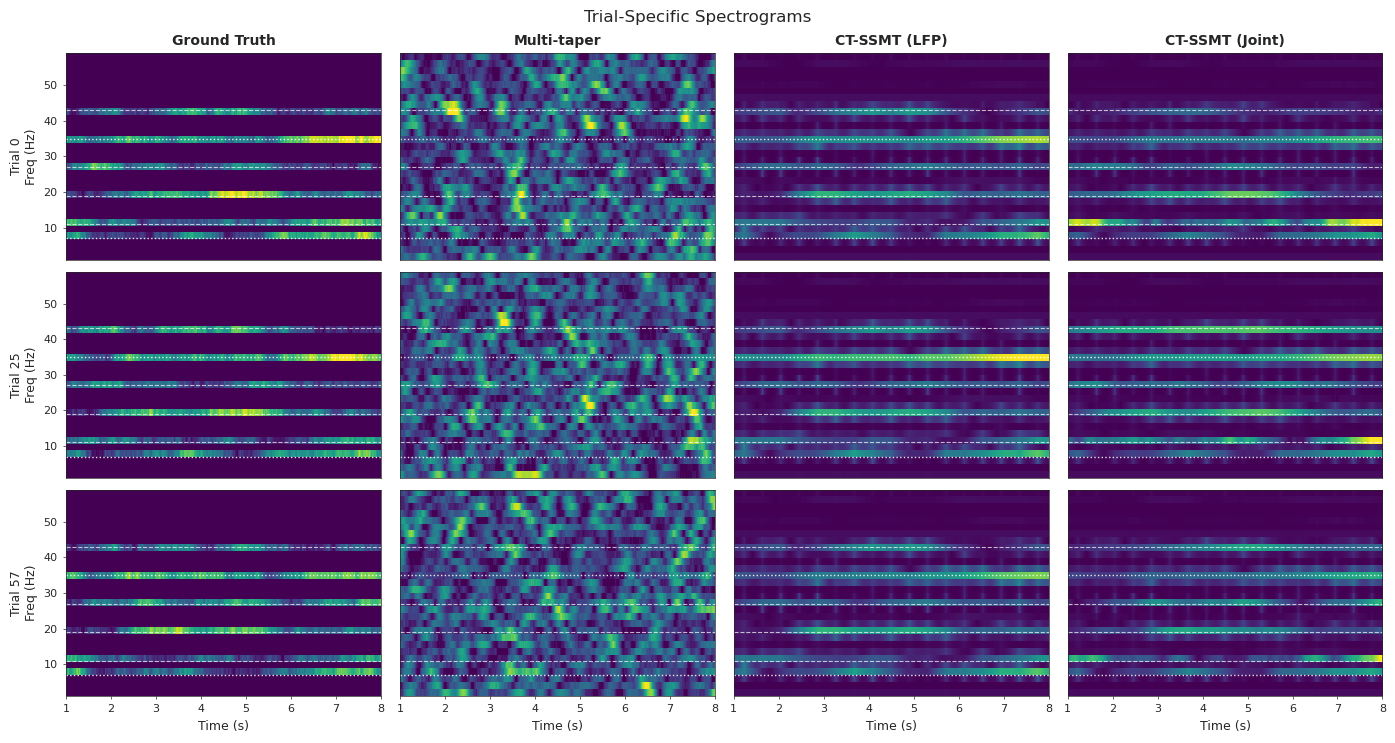

In [15]:
# ============================================================
# PLOT 3: Spectrogram Heatmaps - Trial-Specific
# ============================================================

figure_style(font_size=8)
SAMPLE_TRIALS_SPEC = [0, 25, 57]
n_trials_spec = len(SAMPLE_TRIALS_SPEC)

t_mask_spec = (time >= TIME_RANGE[0]) & (time <= TIME_RANGE[1])
t_plot_spec = time[t_mask_spec]
t_start_idx = np.where(t_mask_spec)[0][0]
t_end_idx = np.where(t_mask_spec)[0][-1] + 1

methods = ['gt', 'mt']
method_labels = ['Ground Truth', 'Multi-taper']
method_data = [Z_gt, Z_mt]
if HAS_LFP:
    methods.append('lfp'); method_labels.append('CT-SSMT (LFP)'); method_data.append(Z_lfp)
if HAS_SPK:
    methods.append('spk'); method_labels.append('CT-SSMT (Joint)'); method_data.append(Z_spk)
n_methods = len(methods)

method_vmax, method_vmin = [], []
for data in method_data:
    all_amps = [np.abs(data[trial_idx, :, t_start_idx:t_end_idx]) for trial_idx in SAMPLE_TRIALS_SPEC]
    method_vmax.append(np.percentile(np.concatenate([a.flatten() for a in all_amps]), 99.9))
    method_vmin.append(np.percentile(np.concatenate([a.flatten() for a in all_amps]), 5))

fig, axes = plt.subplots(n_trials_spec, n_methods, figsize=(3.5*n_methods, 2.5*n_trials_spec))
extent = [t_plot_spec[0], t_plot_spec[-1], FREQS_DENSE[0], FREQS_DENSE[-1]]

for i, trial_idx in enumerate(SAMPLE_TRIALS_SPEC):
    for j, (method, label, data, vmax, vmin) in enumerate(zip(methods, method_labels, method_data, method_vmax, method_vmin)):
        ax = axes[i, j]
        amp = np.abs(data[trial_idx, :, t_start_idx:t_end_idx])
        im = ax.imshow(amp, aspect='auto', origin='lower', extent=extent, cmap='viridis', vmin=vmin, vmax=vmax, interpolation='none')
        for freq_true in freqs_coupled:
            ax.axhline(freq_true, color='white', linestyle='--', lw=0.8, alpha=0.7)
        for freq_true in freqs_extra:
            ax.axhline(freq_true, color='white', linestyle=':', lw=1.0, alpha=0.9)
        if i == 0: ax.set_title(label, fontsize=10, fontweight='bold')
        if j == 0: ax.set_ylabel(f'Trial {trial_idx}\nFreq (Hz)', fontsize=9)
        else: ax.set_yticks([])
        if i == n_trials_spec - 1: ax.set_xlabel('Time (s)', fontsize=9)
        else: ax.set_xticks([])

plt.suptitle('Trial-Specific Spectrograms', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'spectrogram_trial_specific.png'), dpi=150, bbox_inches='tight')
plt.show()

## Figure 5: Spectrogram Heatmaps - Trial-Averaged

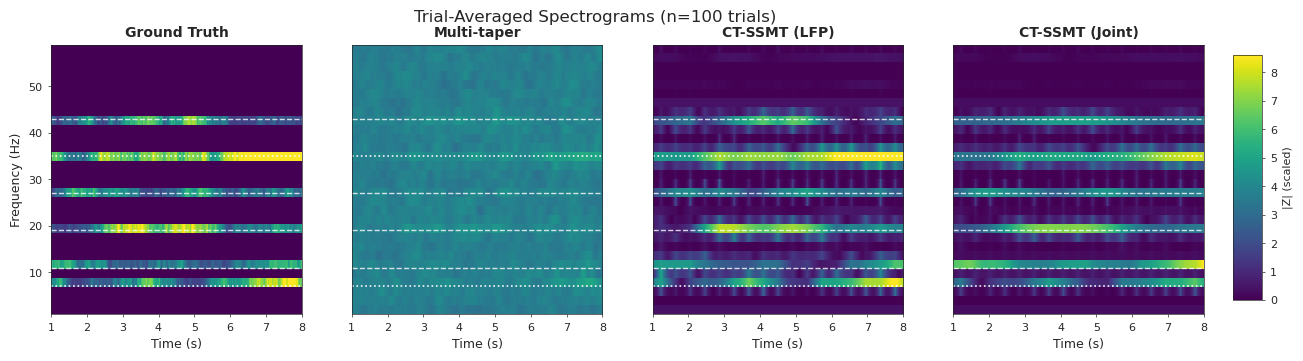

In [16]:
# ============================================================
# PLOT 4: Spectrogram Heatmaps - Trial-Averaged
# ============================================================

figure_style(font_size=8)

Z_gt_avg = np.abs(Z_gt).mean(axis=0)
Z_mt_avg = np.abs(Z_mt).mean(axis=0)
Z_lfp_avg = np.abs(Z_lfp).mean(axis=0) if HAS_LFP else None
Z_spk_avg = np.abs(Z_spk).mean(axis=0) if HAS_SPK else None

avg_data = [Z_gt_avg, Z_mt_avg]
avg_labels = ['Ground Truth', 'Multi-taper']
avg_scales = [1.0, scale_mt_global]
if HAS_LFP:
    avg_data.append(Z_lfp_avg); avg_labels.append('CT-SSMT (LFP)'); avg_scales.append(scale_lfp_global)
if HAS_SPK:
    avg_data.append(Z_spk_avg); avg_labels.append('CT-SSMT (Joint)'); avg_scales.append(scale_spk_global)
n_avg = len(avg_data)

fig, axes = plt.subplots(1, n_avg, figsize=(3.5*n_avg + 0.5, 3.5))
all_amps = [data[:, t_start_idx:t_end_idx] * scale for data, scale in zip(avg_data, avg_scales)]
vmin, vmax = 0, np.percentile(np.concatenate([a.flatten() for a in all_amps]), 99.5)

im = None
for j, (data, label, scale) in enumerate(zip(avg_data, avg_labels, avg_scales)):
    ax = axes[j]
    amp = data[:, t_start_idx:t_end_idx] * scale
    im = ax.imshow(amp, aspect='auto', origin='lower', extent=extent, cmap='viridis', vmin=vmin, vmax=vmax, interpolation='none')
    for freq_true in freqs_coupled:
        ax.axhline(freq_true, color='white', linestyle='--', lw=1.0, alpha=0.8)
    for freq_true in freqs_extra:
        ax.axhline(freq_true, color='white', linestyle=':', lw=1.2, alpha=0.95)
    ax.set_title(label, fontsize=10, fontweight='bold')
    ax.set_xlabel('Time (s)', fontsize=9)
    if j == 0: ax.set_ylabel('Frequency (Hz)', fontsize=9)
    else: ax.set_yticks([])

fig.subplots_adjust(right=0.92)
cbar_ax = fig.add_axes([0.94, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label='|Z| (scaled)')
plt.suptitle(f'Trial-Averaged Spectrograms (n={R} trials)', fontsize=12)
plt.savefig(os.path.join(OUTPUT_DIR, 'spectrogram_trial_averaged.png'), dpi=150, bbox_inches='tight')
plt.show()

## Figure 6: Deviation Spectrograms

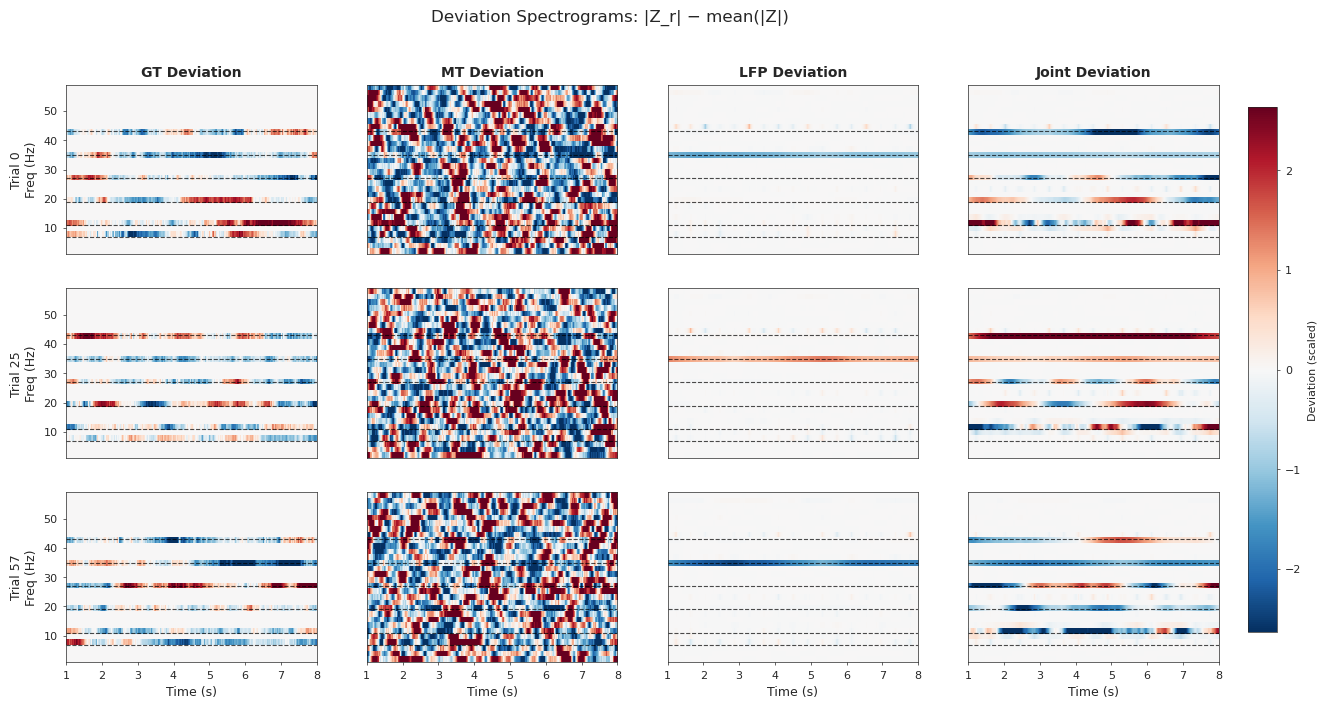

In [17]:
# ============================================================
# PLOT 5: Deviation Spectrograms
# ============================================================

figure_style(font_size=8)

Z_gt_dev_spec = np.abs(Z_gt) - Z_gt_avg[None, :, :]
Z_mt_dev_spec = np.abs(Z_mt) - Z_mt_avg[None, :, :]
Z_lfp_dev_spec = (np.abs(Z_lfp) - Z_lfp_avg[None, :, :]) if HAS_LFP else None
Z_spk_dev_spec = (np.abs(Z_spk) - Z_spk_avg[None, :, :]) if HAS_SPK else None

dev_data = [Z_gt_dev_spec, Z_mt_dev_spec]
dev_labels = ['GT Deviation', 'MT Deviation']
dev_scales = [1.0, scale_mt_global]
if HAS_LFP:
    dev_data.append(Z_lfp_dev_spec); dev_labels.append('LFP Deviation'); dev_scales.append(scale_lfp_global)
if HAS_SPK:
    dev_data.append(Z_spk_dev_spec); dev_labels.append('Joint Deviation'); dev_scales.append(scale_spk_global)
n_dev = len(dev_data)

fig, axes = plt.subplots(n_trials_spec, n_dev, figsize=(3.5*n_dev + 0.5, 2.5*n_trials_spec))

all_devs = [data[trial_idx, :, t_start_idx:t_end_idx] * scale 
            for data, scale in zip(dev_data, dev_scales) for trial_idx in SAMPLE_TRIALS_SPEC]
vmax = np.percentile(np.abs(np.concatenate([d.flatten() for d in all_devs])), 95)
vmin = -vmax

im = None
for i, trial_idx in enumerate(SAMPLE_TRIALS_SPEC):
    for j, (data, label, scale) in enumerate(zip(dev_data, dev_labels, dev_scales)):
        ax = axes[i, j]
        dev = data[trial_idx, :, t_start_idx:t_end_idx] * scale
        im = ax.imshow(dev, aspect='auto', origin='lower', extent=extent, cmap='RdBu_r', vmin=vmin, vmax=vmax, interpolation='none')
        for freq_true in freqs_true:
            ax.axhline(freq_true, color='black', linestyle='--', lw=0.8, alpha=0.7)
        if i == 0: ax.set_title(label, fontsize=10, fontweight='bold')
        if j == 0: ax.set_ylabel(f'Trial {trial_idx}\nFreq (Hz)', fontsize=9)
        else: ax.set_yticks([])
        if i == n_trials_spec - 1: ax.set_xlabel('Time (s)', fontsize=9)
        else: ax.set_xticks([])

fig.subplots_adjust(right=0.92)
cbar_ax = fig.add_axes([0.94, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Deviation (scaled)')
plt.suptitle('Deviation Spectrograms: |Z_r| − mean(|Z|)', fontsize=12)
plt.savefig(os.path.join(OUTPUT_DIR, 'spectrogram_deviation.png'), dpi=150, bbox_inches='tight')
plt.show()

## Figure 7: Correlation Box Plot (All Trials)

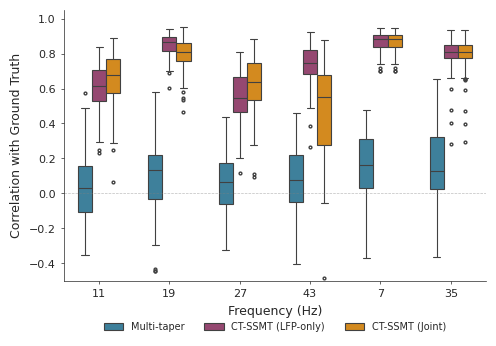


Correlation Summary Statistics (median ± IQR):

11 Hz:
  Multi-taper              : 0.031 ± 0.259
  CT-SSMT (LFP-only)       : 0.616 ± 0.178
  CT-SSMT (Joint)          : 0.679 ± 0.198

19 Hz:
  Multi-taper              : 0.136 ± 0.254
  CT-SSMT (LFP-only)       : 0.868 ± 0.080
  CT-SSMT (Joint)          : 0.809 ± 0.106

27 Hz:
  Multi-taper              : 0.068 ± 0.236
  CT-SSMT (LFP-only)       : 0.546 ± 0.197
  CT-SSMT (Joint)          : 0.638 ± 0.212

43 Hz:
  Multi-taper              : 0.079 ± 0.266
  CT-SSMT (LFP-only)       : 0.746 ± 0.135
  CT-SSMT (Joint)          : 0.551 ± 0.398

7 Hz:
  Multi-taper              : 0.163 ± 0.281
  CT-SSMT (LFP-only)       : 0.880 ± 0.069
  CT-SSMT (Joint)          : 0.880 ± 0.069

35 Hz:
  Multi-taper              : 0.131 ± 0.302
  CT-SSMT (LFP-only)       : 0.810 ± 0.077
  CT-SSMT (Joint)          : 0.811 ± 0.076


In [18]:
# ============================================================
# PLOT: Correlation Distribution Across All Trials (Box Plot)
# ============================================================

figure_style(font_size=8)

def compute_all_trial_correlations(Z_est, Z_gt, freq_indices, time_mask=None):
    """Compute correlation between estimate and ground truth for each trial."""
    R = Z_est.shape[0]
    n_freqs = len(freq_indices)
    correlations = np.zeros((R, n_freqs))
    for i, j_dense in enumerate(freq_indices):
        for r in range(R):
            if time_mask is not None:
                est = np.abs(Z_est[r, j_dense, time_mask])
                gt = np.abs(Z_gt[r, j_dense, time_mask])
            else:
                est = np.abs(Z_est[r, j_dense, :])
                gt = np.abs(Z_gt[r, j_dense, :])
            correlations[r, i] = np.corrcoef(est, gt)[0, 1]
    return correlations

t_mask = (time >= TIME_RANGE[0]) & (time <= TIME_RANGE[1])
corr_mt = compute_all_trial_correlations(Z_mt, Z_gt, idx_true_to_dense, t_mask)
corr_lfp = compute_all_trial_correlations(Z_lfp, Z_gt, idx_true_to_dense, t_mask) if HAS_LFP else None
corr_spk = compute_all_trial_correlations(Z_spk, Z_gt, idx_true_to_dense, t_mask) if HAS_SPK else None

import pandas as pd
data_list = []
for i, freq_hz in enumerate(freqs_true):
    for r in range(R):
        data_list.append({'Frequency (Hz)': f'{int(freq_hz)}', 'Correlation': corr_mt[r, i], 'Method': METHOD_CONFIG['mt']['label']})
        if HAS_LFP:
            data_list.append({'Frequency (Hz)': f'{int(freq_hz)}', 'Correlation': corr_lfp[r, i], 'Method': METHOD_CONFIG['lfp']['label']})
        if HAS_SPK:
            data_list.append({'Frequency (Hz)': f'{int(freq_hz)}', 'Correlation': corr_spk[r, i], 'Method': METHOD_CONFIG['spk']['label']})

df_corr = pd.DataFrame(data_list)

method_order = [METHOD_CONFIG['mt']['label']]
palette = {METHOD_CONFIG['mt']['label']: METHOD_CONFIG['mt']['color']}
if HAS_LFP:
    method_order.append(METHOD_CONFIG['lfp']['label'])
    palette[METHOD_CONFIG['lfp']['label']] = METHOD_CONFIG['lfp']['color']
if HAS_SPK:
    method_order.append(METHOD_CONFIG['spk']['label'])
    palette[METHOD_CONFIG['spk']['label']] = METHOD_CONFIG['spk']['color']

fig, ax = plt.subplots(figsize=(5, 3.5))
sns.boxplot(data=df_corr, x='Frequency (Hz)', y='Correlation', hue='Method',
            hue_order=method_order, palette=palette, width=0.6, linewidth=0.8, fliersize=2, ax=ax)

ax.set_xlabel('Frequency (Hz)', fontsize=9)
ax.set_ylabel('Correlation with Ground Truth', fontsize=9)
ax.set_ylim([-0.5, 1.05])
ax.axhline(0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
ax.legend(title=None, loc='upper center', bbox_to_anchor=(0.5, -0.12), frameon=False, fontsize=7, ncol=3)

sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'correlation_boxplot.pdf'), dpi=150, bbox_inches='tight')
plt.savefig(os.path.join(OUTPUT_DIR, 'correlation_boxplot.png'), dpi=150, bbox_inches='tight')
plt.show()

print("\nCorrelation Summary Statistics (median ± IQR):")
print("="*70)
for i, freq_hz in enumerate(freqs_true):
    print(f"\n{freq_hz:.0f} Hz:")
    print(f"  {METHOD_CONFIG['mt']['label']:<25}: {np.median(corr_mt[:, i]):.3f} ± {np.percentile(corr_mt[:, i], 75) - np.percentile(corr_mt[:, i], 25):.3f}")
    if HAS_LFP:
        print(f"  {METHOD_CONFIG['lfp']['label']:<25}: {np.median(corr_lfp[:, i]):.3f} ± {np.percentile(corr_lfp[:, i], 75) - np.percentile(corr_lfp[:, i], 25):.3f}")
    if HAS_SPK:
        print(f"  {METHOD_CONFIG['spk']['label']:<25}: {np.median(corr_spk[:, i]):.3f} ± {np.percentile(corr_spk[:, i], 75) - np.percentile(corr_spk[:, i], 25):.3f}")

## Figure 8: Power Spectral Density Comparison

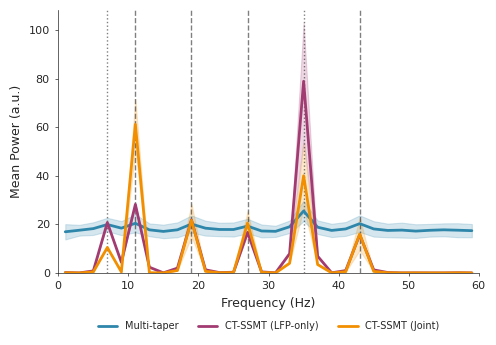


SNR Analysis (Signal vs. Off-Signal Frequencies):
Method                             P_signal      P_noise        SNR
----------------------------------------------------------------------
Multi-taper                         20.9413    17.783948        1.2
CT-SSMT (LFP-only)                  30.3808     1.221473       24.9
CT-SSMT (Joint)                     28.3267     0.493483       57.4
----------------------------------------------------------------------

SNR Improvement over Multi-taper:
  CT-SSMT (LFP-only): 21.12x
  CT-SSMT (Joint): 48.75x


In [19]:
# ============================================================
# PLOT: Power Spectral Density Comparison
# ============================================================

figure_style(font_size=8)

def compute_psd_stats(Z, axis_time=2):
    """Compute mean and std of power spectral density across trials."""
    power_per_trial = np.mean(np.abs(Z) ** 2, axis=axis_time)
    psd_mean = np.mean(power_per_trial, axis=0)
    psd_std = np.std(power_per_trial, axis=0)
    return psd_mean, psd_std

psd_mt_mean, psd_mt_std = compute_psd_stats(Z_mt)
psd_mt_mean *= (scale_mt_global ** 2)
psd_mt_std *= (scale_mt_global ** 2)

if HAS_LFP:
    psd_lfp_mean, psd_lfp_std = compute_psd_stats(Z_lfp)
    psd_lfp_mean *= (scale_lfp_global ** 2)
    psd_lfp_std *= (scale_lfp_global ** 2)

if HAS_SPK:
    psd_spk_mean, psd_spk_std = compute_psd_stats(Z_spk)
    psd_spk_mean *= (scale_spk_global ** 2)
    psd_spk_std *= (scale_spk_global ** 2)

fig, ax = plt.subplots(figsize=(5, 3.5))

ax.fill_between(FREQS_DENSE, psd_mt_mean - psd_mt_std, psd_mt_mean + psd_mt_std,
                color=METHOD_CONFIG['mt']['color'], alpha=0.2)
ax.plot(FREQS_DENSE, psd_mt_mean, color=METHOD_CONFIG['mt']['color'], 
        linewidth=2, label=METHOD_CONFIG['mt']['label'], zorder=2)

if HAS_LFP:
    ax.fill_between(FREQS_DENSE, psd_lfp_mean - psd_lfp_std, psd_lfp_mean + psd_lfp_std,
                    color=METHOD_CONFIG['lfp']['color'], alpha=0.2)
    ax.plot(FREQS_DENSE, psd_lfp_mean, color=METHOD_CONFIG['lfp']['color'], 
            linewidth=2, label=METHOD_CONFIG['lfp']['label'], zorder=3)

if HAS_SPK:
    ax.fill_between(FREQS_DENSE, psd_spk_mean - psd_spk_std, psd_spk_mean + psd_spk_std,
                    color=METHOD_CONFIG['spk']['color'], alpha=0.2)
    ax.plot(FREQS_DENSE, psd_spk_mean, color=METHOD_CONFIG['spk']['color'], 
            linewidth=2, label=METHOD_CONFIG['spk']['label'], zorder=4)

for freq_hz in freqs_true:
    ls = ':' if int(freq_hz) in freqs_extra_set else '--'
    ax.axvline(freq_hz, color='black', linestyle=ls, linewidth=1, alpha=0.5, zorder=1)

ax.set_xlabel('Frequency (Hz)', fontsize=9)
ax.set_ylabel('Mean Power (a.u.)', fontsize=9)
ax.set_xlim([FREQS_DENSE[0] - 1, FREQS_DENSE[-1] + 1])
ax.set_ylim(bottom=0)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), frameon=False, fontsize=7, ncol=3)

sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'psd_comparison.pdf'), dpi=150, bbox_inches='tight')
plt.savefig(os.path.join(OUTPUT_DIR, 'psd_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

# SNR Analysis
def compute_snr_metrics(psd, freq_indices, all_freqs):
    signal_mask = np.zeros(len(all_freqs), dtype=bool)
    signal_mask[freq_indices] = True
    power_signal = np.mean(psd[signal_mask])
    power_noise = np.mean(psd[~signal_mask])
    snr = power_signal / power_noise if power_noise > 0 else np.inf
    return power_signal, power_noise, snr

print("\nSNR Analysis (Signal vs. Off-Signal Frequencies):")
print("="*70)
print(f"{'Method':<30} {'P_signal':>12} {'P_noise':>12} {'SNR':>10}")
print("-"*70)

p_sig_mt, p_noise_mt, snr_mt = compute_snr_metrics(psd_mt_mean, idx_true_to_dense, FREQS_DENSE)
print(f"{METHOD_CONFIG['mt']['label']:<30} {p_sig_mt:>12.4f} {p_noise_mt:>12.6f} {snr_mt:>10.1f}")

if HAS_LFP:
    p_sig_lfp, p_noise_lfp, snr_lfp = compute_snr_metrics(psd_lfp_mean, idx_true_to_dense, FREQS_DENSE)
    print(f"{METHOD_CONFIG['lfp']['label']:<30} {p_sig_lfp:>12.4f} {p_noise_lfp:>12.6f} {snr_lfp:>10.1f}")

if HAS_SPK:
    p_sig_spk, p_noise_spk, snr_spk = compute_snr_metrics(psd_spk_mean, idx_true_to_dense, FREQS_DENSE)
    print(f"{METHOD_CONFIG['spk']['label']:<30} {p_sig_spk:>12.4f} {p_noise_spk:>12.6f} {snr_spk:>10.1f}")

print("-"*70)
print("\nSNR Improvement over Multi-taper:")
if HAS_LFP:
    print(f"  {METHOD_CONFIG['lfp']['label']}: {snr_lfp / snr_mt:.2f}x")
if HAS_SPK:
    print(f"  {METHOD_CONFIG['spk']['label']}: {snr_spk / snr_mt:.2f}x")